<h1>RBM implementation - training - inference </h1>


In [1]:
# importing some basic libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
# getting the data and binarizing it
df = pd.read_csv('mnist_train.csv', header = None)  #reading from .csv file
npdf = np.array(df)

# images and labels separation
labels = npdf[:,0].reshape(-1,1)
images = npdf[:, 1:]

data = images.copy()
images = images.reshape(-1, 28, 28)

# binarization
images[images <= 127] = 0
images[images >= 127] = 1

print("Shape of training data", images.shape)

Shape of training data (60000, 28, 28)


In [4]:
class RBM:
    """This class implements Restricted Boltzman Machin Using Gibbs sampling
       and Contrastive Divergence"""
    
    def __init__(self, n_hidden_layer_size=77, m_observed_inputs=784, K=3):
        
        '''Here we do some necessary initialization '''
        
        np.random.seed(3)           ## fixing the random seeds to get consistant results
        
        
        
        self.K = K                     # number of steps in Gibb's chain
        self.learning_rate = 0.025      # will be used in update equation
        
        self.n = n_hidden_layer_size         # our input(visible) and hidder layer size
        self.m = m_observed_inputs
        
        # m => observed(visible) size
        # n => hidden layer size

        self.weight = np.random.rand(self.m, self.n) * 0.01    # (visible, hidden)
        self.b = np.random.rand(self.m, 1) * 0.01              # (visble, 1)
        self.c = np.random.rand(self.n, 1) * 0.01              # (hidden, 1)
        
        
        # initializing velocity for momentum term
        self.velocity_w = 0   
        self.velocity_b = 0
        self.velocity_c = 0
        
        
        self.reg_lambda = 1e-5 # constant which controls the regularization
        self.beta = 0.9     # constant which controls value of momentum
        
    # get the sigmoid of given matrix of vector
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # forward function of Gibb's sampling
    def forward(self, image):
        hidden_distribution = self.sigmoid(self.weight.T @ image + self.c)  # (hidden, 1)
        return np.random.binomial(1, hidden_distribution)                     # (hidden, 1)
    
    
    # backward function for Gibb's sampling
    def backward(self, hidden_representation):
        visible_distribution = self.sigmoid(self.weight @ hidden_representation + self.b)  # [visible, 1]
        return np.random.binomial(1,visible_distribution)                                # [visible, 1]

     
    # training the RBM using Gibbs sampling and Contrastive divergence
    def train(self, Xtrain, epochs):
        
        Xtrain = Xtrain.reshape(-1, self.m)
        
        for e in range(epochs):
            
            self.energy_history = []

            start = time.time()           
            for index in range(len(Xtrain)):
                self.contrastive_divergence(Xtrain[index])
            time_taken = time.time() - start                   # to know how much time one iteration takes

            mean_energy = np.mean(self.energy_history)
            print("[In Epoch : {}] ==================================".format(e+1))
            print("average energy : {:.3f}   | Time Taken : {:.3f}sec".format(mean_energy, time_taken))
    

        print("=================== TRAINING ENDED =====================")
    
    

    

    def contrastive_divergence(self, initial_visible):
        
        initial_visible = initial_visible.reshape(-1, 1)
        hidden_original_sample = self.forward(initial_visible)
        
        # Running Gibbs chain for K steps
        visible_sample, hidden_from_gibbs = self.Gibbs_sampling(initial_visible, self.K)

        #UPDATING THE PARAMETERS USING MOMENTUM AND WEIGHT DECAY
        
        # weight update
        self.velocity_w = self.beta * self.velocity_w + (1-self.beta)* (initial_visible @ hidden_original_sample.T - visible_sample @ hidden_from_gibbs.T)
        self.weight = (1-self.reg_lambda)* self.weight + self.learning_rate * self.velocity_w
        
        # bias 'b' update
        self.velocity_b = self.beta * self.velocity_b + (1-self.beta)* (initial_visible - visible_sample) 
        self.b += self.learning_rate * self.velocity_b
        
        # bias 'c' update
        self.velocity_c = self.beta * self.velocity_c + (1-self.beta) * (hidden_original_sample - hidden_from_gibbs)
        self.c += self.learning_rate * self.velocity_c

        
        self.energy_history.append(self.energy(initial_visible, hidden_from_gibbs))

    

    def energy(self, vis, hidd):
        
        """ Cacluates enegry of the function given visible and hidden samples
        
        Args : vis - visible state sample
               hidd - hidden state sample
               
        return : energy
        
        """
        
        term_1 = (vis.T @ self.weight) @ hidd
        term_2 = vis.reshape(1, -1) @ self.b
        term_3 = hidd.reshape(1, -1) @ self.c
        
        energy = -np.squeeze(term_1 + term_2 + term_3)
        
        return energy
    
    
    def Gibbs_sampling(self, initial_visible, K):
        
        '''This functino runs Gibbs chaing for given number of 'K' steps
        
        Args : initial_visible - first value of visible state(initializing Gibbs chain)
               K - number of steps in Gibbs chain
        returns : vt - visble state after 'K' steps 
                  ht - hidden state aftter 'K' steps'''
        vt = initial_visible.reshape(-1, 1)
        
        for k in range(K):
            ht = self.forward(vt)
            vt = self.backward(ht)  # (visible, 1)

        return vt, ht

    def fantasy_samples(self, initial_image, K):
        """This function will get us the fantasy images after training for 'K' steps."""
        v, h = self.Gibbs_sampling(initial_image, K)
        return v

In [5]:
n_hidden_layer_size=128
m_observed_inputs=784 
K=2                    # number of steps to run Gibbs chain

# instantiating the RBM class
rbm_model = RBM(n_hidden_layer_size, m_observed_inputs,  K)

In [6]:
# training rbm_model on data 'images[0: 49999]'

''' TRAINING DATA  --- images[0:49999]         <50,000 images>
    TEST DATA      --- images[50000, 59999]    <10,000 images>
    
    We will use our model to create fantasy images for test_data and see how good
    our model generalizes'''
rbm_model.train(images, epochs=3)

[In Epoch : 1] ==================================
average energy : -171.787   | Time Taken : 106.777sec
[In Epoch : 2] ==================================
average energy : -223.692   | Time Taken : 112.146sec
[In Epoch : 3] ==================================
average energy : -238.017   | Time Taken : 111.303sec
=================== TRAINING ENDED =====================


In [7]:
# Getting the learnt featurs from rbm_model for training a softmax classifier.
learned_features = np.zeros((n_hidden_layer_size, 60000))
for i in range(60000):
    learned_features[:, i] = rbm_model.forward(data[i].reshape(-1, 1)).reshape(-1,)
learned_features = learned_features.T
print('Shape of learnt features ', learned_features.shape)

Shape of learnt features  (60000, 128)


<h2> Creating Fantasy images for TRAINING DATA</h2>
<p> As we pick images randomly so run again the cell to see generation for different images.</p

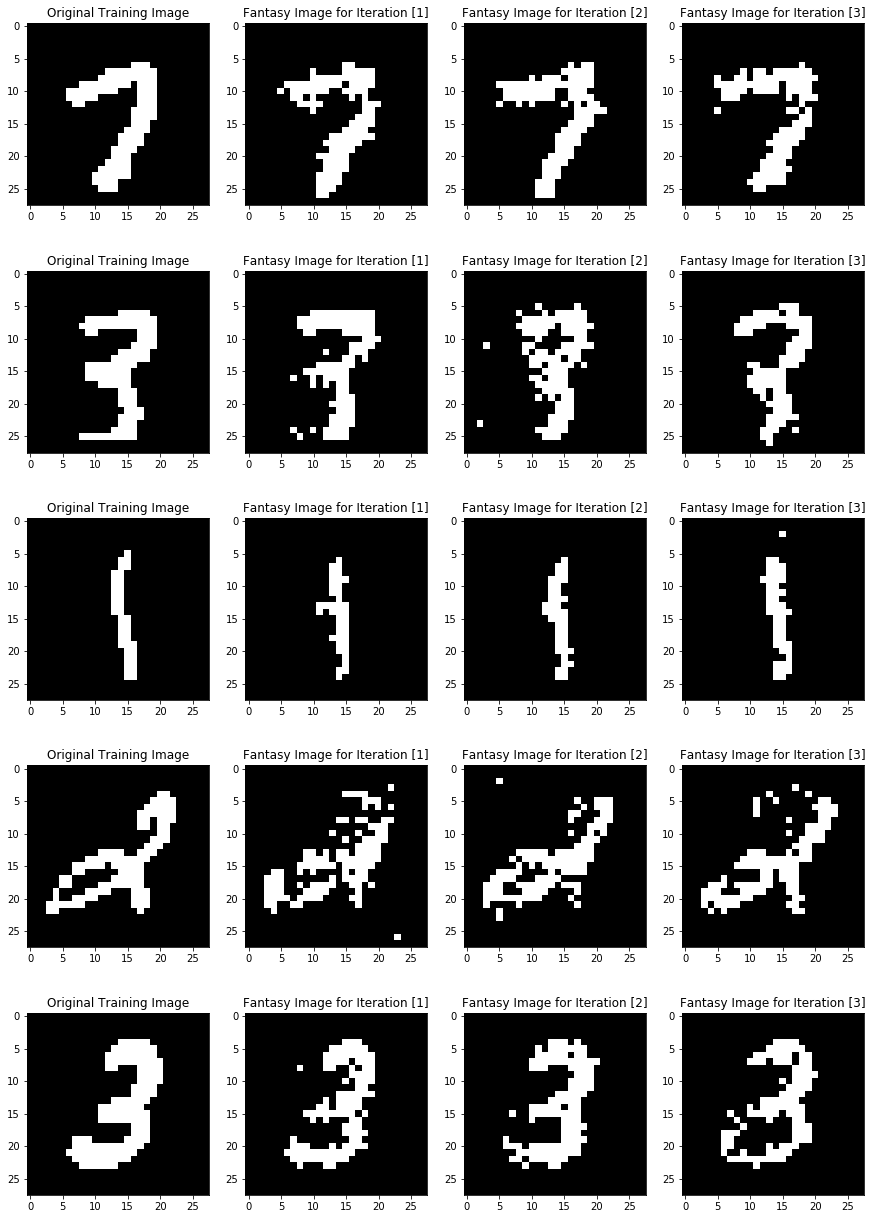

In [10]:
# Getting some random samples from training data and see the Evolution for 3 steps
fig = plt.figure(figsize = (15,  22))

for j in range(1, 20, 4):
    
    # Getting training images randomly from "TRAINING DATA"
    image_index = int(np.random.randint(0,49999,1))
    
    ax = fig.add_subplot(5, 4, j)
    plt.imshow(images[image_index], cmap = 'gray')
    ax.set_title("Original Training Image")

    for i in range(1, 4):
        v = rbm_model.fantasy_samples(images[image_index], K=i)
        ax = fig.add_subplot(5, 4, i+j)
        plt.imshow(v.reshape((28, 28)), cmap="gray")
        ax.set_title("Fantasy Image for Iteration [" +str(i)+']')

<h2> Creating Fantasy images for TEST DATA </h2>
<p> As we pick images randomly so run again the cell to see generation for different images.</p>

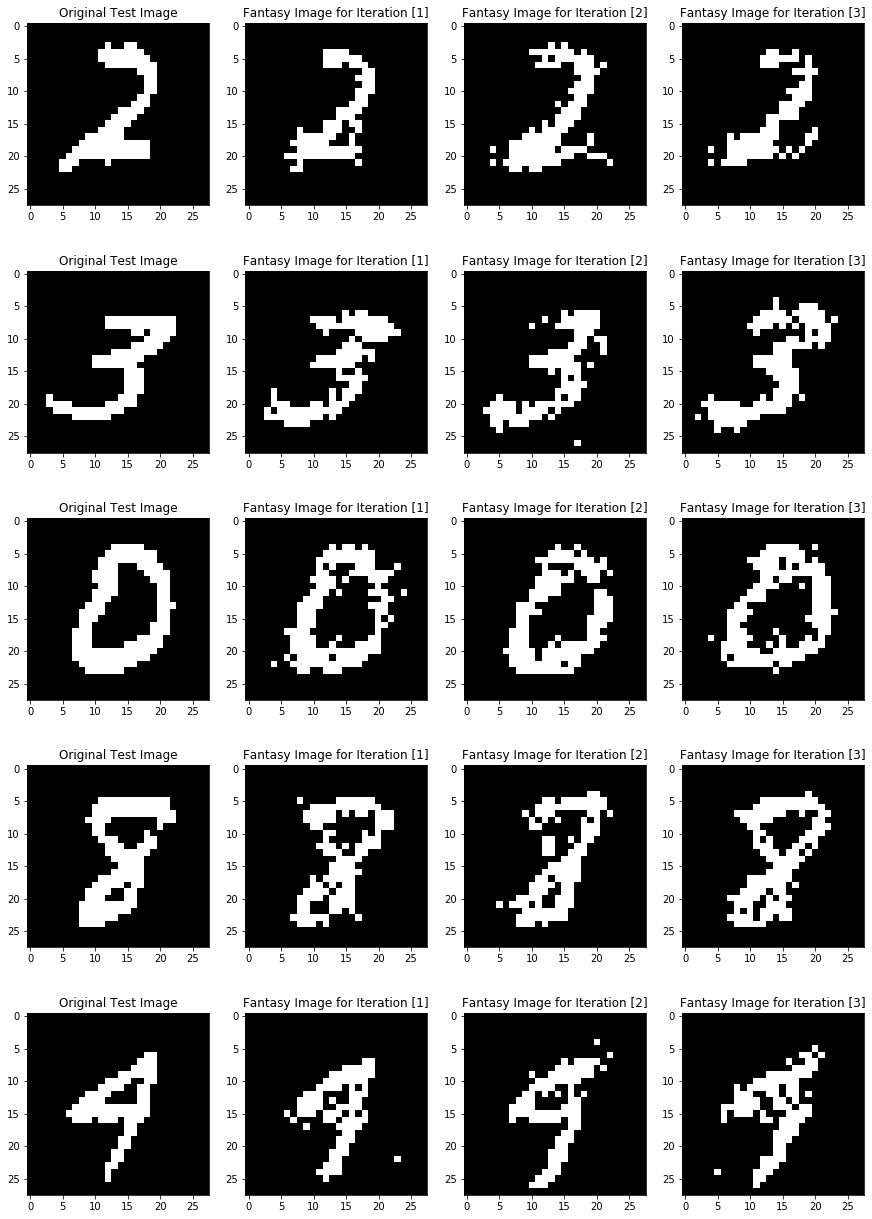

In [11]:
# Getting some random samples from training data and see the Evolution for 3 steps
fig = plt.figure(figsize = (15,  22))

for j in range(1, 20, 4):
    # Getting test images randomly from "TEST DATA"
    image_index = int(np.random.randint(50000,59999,1)) 
    
    ax = fig.add_subplot(5, 4, j)
    plt.imshow(images[image_index], cmap = 'gray')
    ax.set_title("Original Test Image")

    for i in range(1, 4):
        v = rbm_model.fantasy_samples(images[image_index], K=i)
        ax = fig.add_subplot(5, 4, i+j)
        plt.imshow(v.reshape((28, 28)), cmap="gray")
        ax.set_title("Fantasy Image for Iteration [" +str(i)+']')


<h2>Comparing direct classfication of pixels and learned RBM features.</h2>
<p> Let's first write some necessary functions for using Softmax classifier</p>

In [16]:
# this function prepares data as per requirement of our models

def data_prep(X, labels):
    """ Args : X  - images/features of shape (n * m)   m - no of samples
                                              m - no of features/pixels"""
    
    npXtrain = X[:40000]
    
    mean = npXtrain.mean(axis = 0)
    std =  npXtrain.std(axis = 0) + 1e-10

    npXtrain = (npXtrain - mean) / std                     # normlization of train set
    
    npYtrain = labels[:40000].reshape(-1,).astype(int)
    npYtrain = np.eye(10)[npYtrain]
    
    
    Xval = X[40000: 50000]
    
    Xval = (Xval - mean) / std
    Yval = labels[40000:50000].reshape(-1,).astype(int)
    Yval = np.eye(10)[Yval]
    
    
    Xtest = X[50000: 60000]
    
    Xtest = (Xtest - mean) / std
    Ytest = labels[50000:60000].reshape(-1,).astype(int)
    Ytest = np.eye(10)[Ytest]
    
    
    print('nptrain  shape', npXtrain.shape)
    print('npYtrain  shape', npYtrain.shape)
    print('Xval  shape', Xval.shape)
    print('Yval  shape', Yval.shape)
    print('Xtest  shape', Xtest.shape)
    print('Ytest  shape ', Ytest.shape)
    
    return npXtrain, npYtrain, Xval.T, Yval.T, Xtest.T, Ytest.T

In [17]:
def train_the_model(model, batch_size, learning_rate, beta, epochs):
    """ This function will train the model, do the prediction for labels, calculate the train & test accuracy.
    
    agrs          ::::    model          -  object of myNN class
                          batch_size     -  batch size of training dataset
                          learning_rate  -  learning rate of training
                          beta           -  constant that controls the momentum
                          epochs         -
                          
    returns       ::::    train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history 
                          These list contains correponding values calculated over an epoch.
    """
    total_batches = int(len(npXtrain) / batch_size)                          # total batches of training dataset in one epoch                                  
    # creating empty lists to save the history
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for e in range(epochs):

        running_train_accuracy = 0.0
        running_train_loss = 0.0

        for i in range(total_batches):                                      # Implenting SGD with momentum and L2 decay
            Xtrain = npXtrain[i * batch_size : (i+1) * batch_size].T        # slicing the full training dataset into batches
            Ytrain = npYtrain[i * batch_size : (i+1) * batch_size].T

            train_outputs = model.forward(Xtrain)                           # forward pass on train batch
            train_loss = model.loss(train_outputs, Ytrain)                  # calculating the current loss on current train batch
            grads = model.backward(train_outputs, Ytrain)                   # backwad pass and gradient calculation
            model.update(grads, learning_rate, beta)                              # updating the weights

            train_predict = np.argmax(train_outputs, axis = 0)              # getting the predicted labels for train batch
            train_gt = np.argmax(Ytrain, axis = 0)                          # getting the ground truth label from one hot encoded matrix

            running_train_accuracy += np.mean((train_predict == train_gt))  # accumulating the batch accuracy
            running_train_loss += train_loss                                # accumulating the batch loss

        val_outputs = model.forward(Xval)                                   # forward pass on validation set
        val_loss = model.loss(val_outputs, Yval)                            # loss calculating on validation set

        val_predict = np.argmax(val_outputs, axis = 0)                      # getting the predicted labels for validation set
        val_gt = np.argmax(Yval, axis = 0)                                   # getting the ground truth labels from one hot encoded matrix

        epoch_val_accuracy = np.mean((val_predict == val_gt)) * 100         # calculating the val accuracy
        epoch_train_accuracy = 100 * (running_train_accuracy / total_batches)    # calculating the train accuracy for epoch
        epoch_train_loss = running_train_loss / total_batches               # calculating the train loss for epoch

        # appending correspond values to their list history
        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(val_loss)
        train_accuracy_history.append(epoch_train_accuracy)
        val_accuracy_history.append(epoch_val_accuracy)
        
        #printing out out stats
        if e % 30 == 0:
            print("======================================================")
            print("Epoch : {}".format(e+1))
            print("Train Loss     : {:.3f},   Validation Loss     : {:.3f}".format(epoch_train_loss, val_loss))
            print("Train Accuracy : {:.3f}%,  Valdiation Accuracy : {:.3f}%".format(epoch_train_accuracy, epoch_val_accuracy))
            
    print("===========================TRAINING COMPLETE ==================================")
    test_outputs = model.forward(Xtest)                                 # forward pass on test set
    test_loss = model.loss(test_outputs, Ytest)                         # loss calculating on test set
    test_predict = np.argmax(test_outputs, axis = 0)                    # getting the predicted labels for test set
    test_gt = np.argmax(Ytest, axis = 0)                                # getting the ground truth labels from one hot encoded matrix

    epoch_test_accuracy = np.mean((test_predict == test_gt)) * 100      # calculating the test accuracy
    print("Test Loss : {:.3f} and Test Accuracy : {:.3f}%  ".format(test_loss,epoch_test_accuracy))
    
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [18]:
def plots(train_loss, val_loss, train_acc, val_acc):
    """This functions just draw the loss and accuracy plots obtained after training the model
    
    args ::::  train_loss  -   train_loss_history
               val_loss   -   val_loss_history
               train_acc   -   train_accuracy_history
               val_acc    -   val_accuracy_history
    """

    fig = plt.figure(figsize = (20, 10))

    ax = fig.add_subplot(1, 2, 1)
    plt.plot(train_loss, label = 'Train Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.title('Loss Plots')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(train_acc, label = 'Train Accuracy')
    plt.plot(val_acc, label = 'Validation Accuracy')
    plt.title("Accuracy Plots")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy in percent(%)")
    plt.legend()

In [19]:
# mySoftmax class is written in 'softmax_classifier.py' 
# importing the mySoftmax class which trains a softmax classfier using L2 regularization
# and Cross entropy loss

from softmax_classifier import mySoftmax

<h1> Training the Softmax Classifier on flattened image directly using pixel values </h1>

nptrain  shape (40000, 784)
npYtrain  shape (40000, 10)
Xval  shape (10000, 784)
Yval  shape (10000, 10)
Xtest  shape (10000, 784)
Ytest  shape  (10000, 10)
Epoch : 1
Train Loss     : 4.318,   Validation Loss     : 3.929
Train Accuracy : 10.285%,  Valdiation Accuracy : 12.120%
Epoch : 31
Train Loss     : 0.914,   Validation Loss     : 0.785
Train Accuracy : 76.082%,  Valdiation Accuracy : 77.770%
Epoch : 61
Train Loss     : 0.687,   Validation Loss     : 0.581
Train Accuracy : 82.498%,  Valdiation Accuracy : 83.400%
Epoch : 91
Train Loss     : 0.597,   Validation Loss     : 0.504
Train Accuracy : 84.877%,  Valdiation Accuracy : 85.970%
Epoch : 121
Train Loss     : 0.546,   Validation Loss     : 0.462
Train Accuracy : 86.270%,  Valdiation Accuracy : 87.170%
Epoch : 151
Train Loss     : 0.512,   Validation Loss     : 0.435
Train Accuracy : 87.197%,  Valdiation Accuracy : 88.170%
Epoch : 181
Train Loss     : 0.487,   Validation Loss     : 0.415
Train Accuracy : 87.892%,  Valdiation Accura

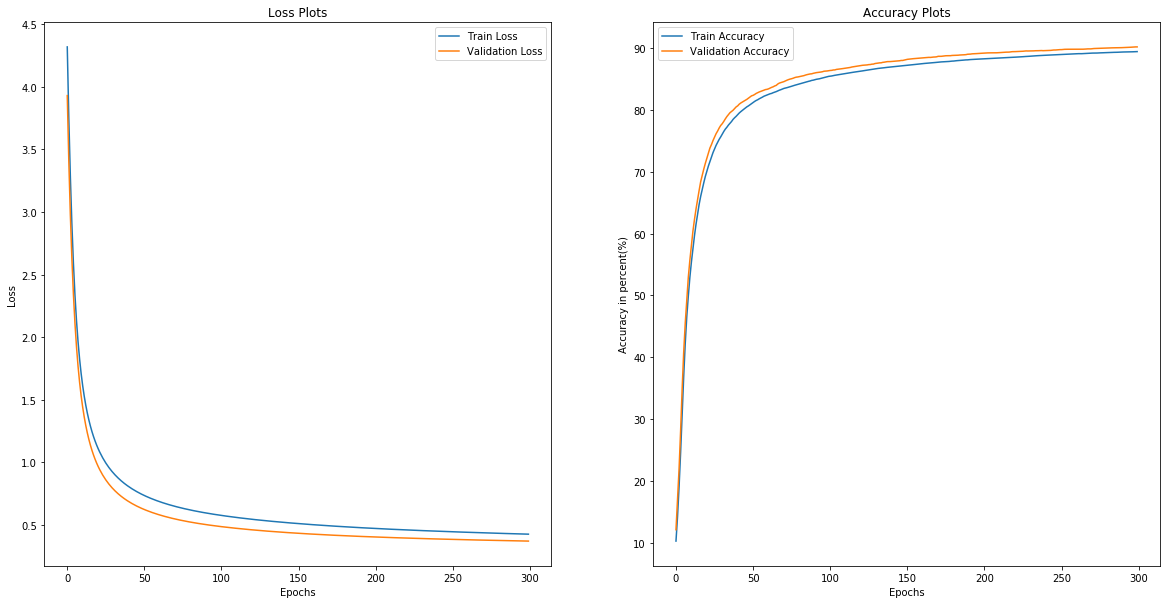

In [20]:
CLASS = 10                                                         # Number of classes(2 or 5)

BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCH = 300
MOMENTUM_BETA = 0.9

npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = data_prep(data, labels)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = mySoftmax([in_ft, CLASS], reg_lambda = 0.1)  # defining model architechture and regulariztion constant labmda


# training the model
train_loss, val_loss, train_acc, val_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, MOMENTUM_BETA, EPOCH)
plots(train_loss, val_loss, train_acc, val_acc)

<h1> Training the Softmax Classifier on RBM features. </h1>

nptrain  shape (40000, 128)
npYtrain  shape (40000, 10)
Xval  shape (10000, 128)
Yval  shape (10000, 10)
Xtest  shape (10000, 128)
Ytest  shape  (10000, 10)
Epoch : 1
Train Loss     : 2.701,   Validation Loss     : 2.608
Train Accuracy : 15.720%,  Valdiation Accuracy : 16.750%
Epoch : 31
Train Loss     : 1.013,   Validation Loss     : 0.941
Train Accuracy : 71.547%,  Valdiation Accuracy : 73.940%
Epoch : 61
Train Loss     : 0.721,   Validation Loss     : 0.651
Train Accuracy : 80.938%,  Valdiation Accuracy : 82.760%
Epoch : 91
Train Loss     : 0.602,   Validation Loss     : 0.536
Train Accuracy : 84.262%,  Valdiation Accuracy : 86.140%
Epoch : 121
Train Loss     : 0.538,   Validation Loss     : 0.474
Train Accuracy : 85.870%,  Valdiation Accuracy : 87.610%
Epoch : 151
Train Loss     : 0.497,   Validation Loss     : 0.435
Train Accuracy : 86.803%,  Valdiation Accuracy : 88.430%
Epoch : 181
Train Loss     : 0.468,   Validation Loss     : 0.408
Train Accuracy : 87.455%,  Valdiation Accura

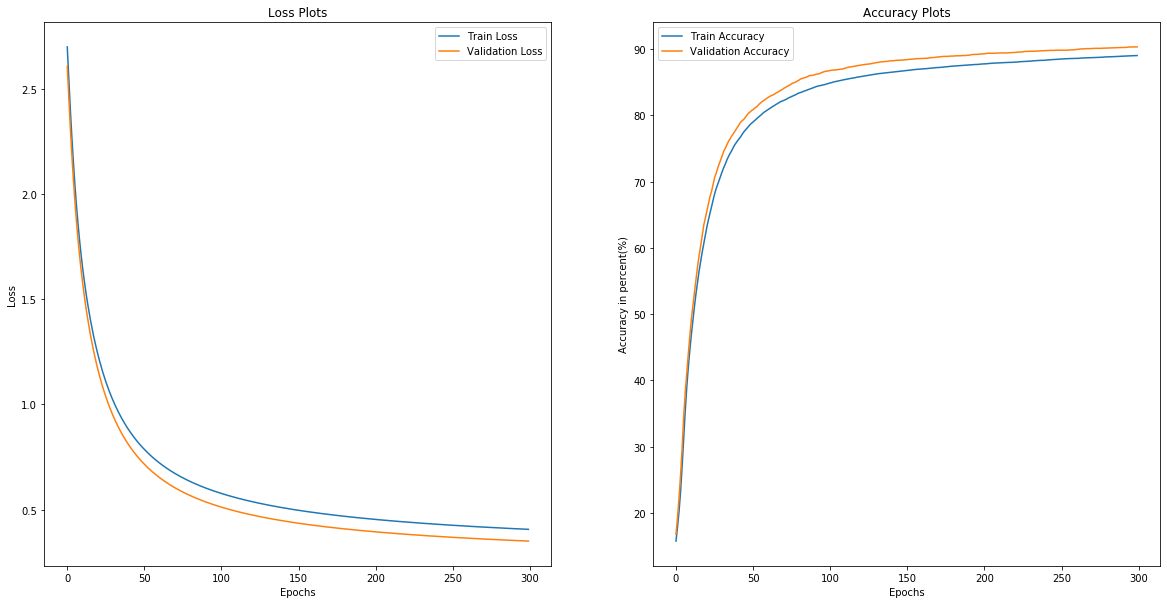

In [21]:
CLASS = 10                                                         # Number of classes(2 or 5)

BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCH = 300
MOMENTUM_BETA = 0.9

npXtrain, npYtrain, Xtest, Ytest, Xval, Yval = data_prep(learned_features, labels)          # Getting the data

in_ft = Xtest.shape[0]                                             # dimensions of input features
model = mySoftmax([in_ft, CLASS], 0.1)                           # defining model architechture


# training the model
train_loss, val_loss, train_acc, val_acc = train_the_model(model, BATCH_SIZE, LEARNING_RATE, MOMENTUM_BETA, EPOCH)
plots(train_loss, val_loss, train_acc, val_acc)

<h1>Conclusions and comparision :</h1>
<ul>
    <li>Softmax Classifier runs faster on rbm featurs dues to less number of vairalbel.</li>
    <li>Our Softmax classfir achieves better accuracy on validation and test set on rbm features.</li>
     <li>As we have used L2 regularization so our classifier does not overfit the data.</li>
</ul>

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h3>Performance on direct pixel values :</h3>

<table>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>89.180%</td>
  </tr>
      <tr>
    <td><b>Validation Accuracy</b></td>
    <td>89.890%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>88.120%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>64</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>300</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD -L2 regularization(lambda = 0.1)</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>1e-4</td>
  </tr>
</table>

<style>
table {
  width:100%;
}
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 15px;
  text-align: left;
}
table tr:nth-child(even) {
  background-color: #eee;
}
table tr:nth-child(odd) {
 background-color: #fff;
}
table th {
  background-color: black;
  color: white;
}
</style>

<h3>Performance on RBM featurs :</h3>

<table>
  <tr>
    <td><b>Train Accuracy </b></td>
    <td>88.733%</td>
  </tr>
      <tr>
    <td><b>Validation Accuracy</b></td>
    <td>90.110%</td>
  </tr>
  <tr>
    <td><b>Test Accuracy</b></td>
    <td>88.660%</td>
  </tr>
    <tr>
    <td><b>Batch Size</b></td>
    <td>64</td>
  </tr>
    <tr>
    <td><b>Epochs</b></td>
    <td>300</td>
  </tr>
    <tr>
    <td><b>Optimizer</b></td>
    <td>SGD -L2 regularization(lambda = 0.1)</td>
  </tr>
    <tr>
    <td><b>Learning Rate</b></td>
    <td>1e-4</td>
  </tr>
</table>

<h1> ================== THE END ================ </h1>